In [1]:
%matplotlib widget
# %load_ext autoreload
# %autoreload 2
from fig11code import *

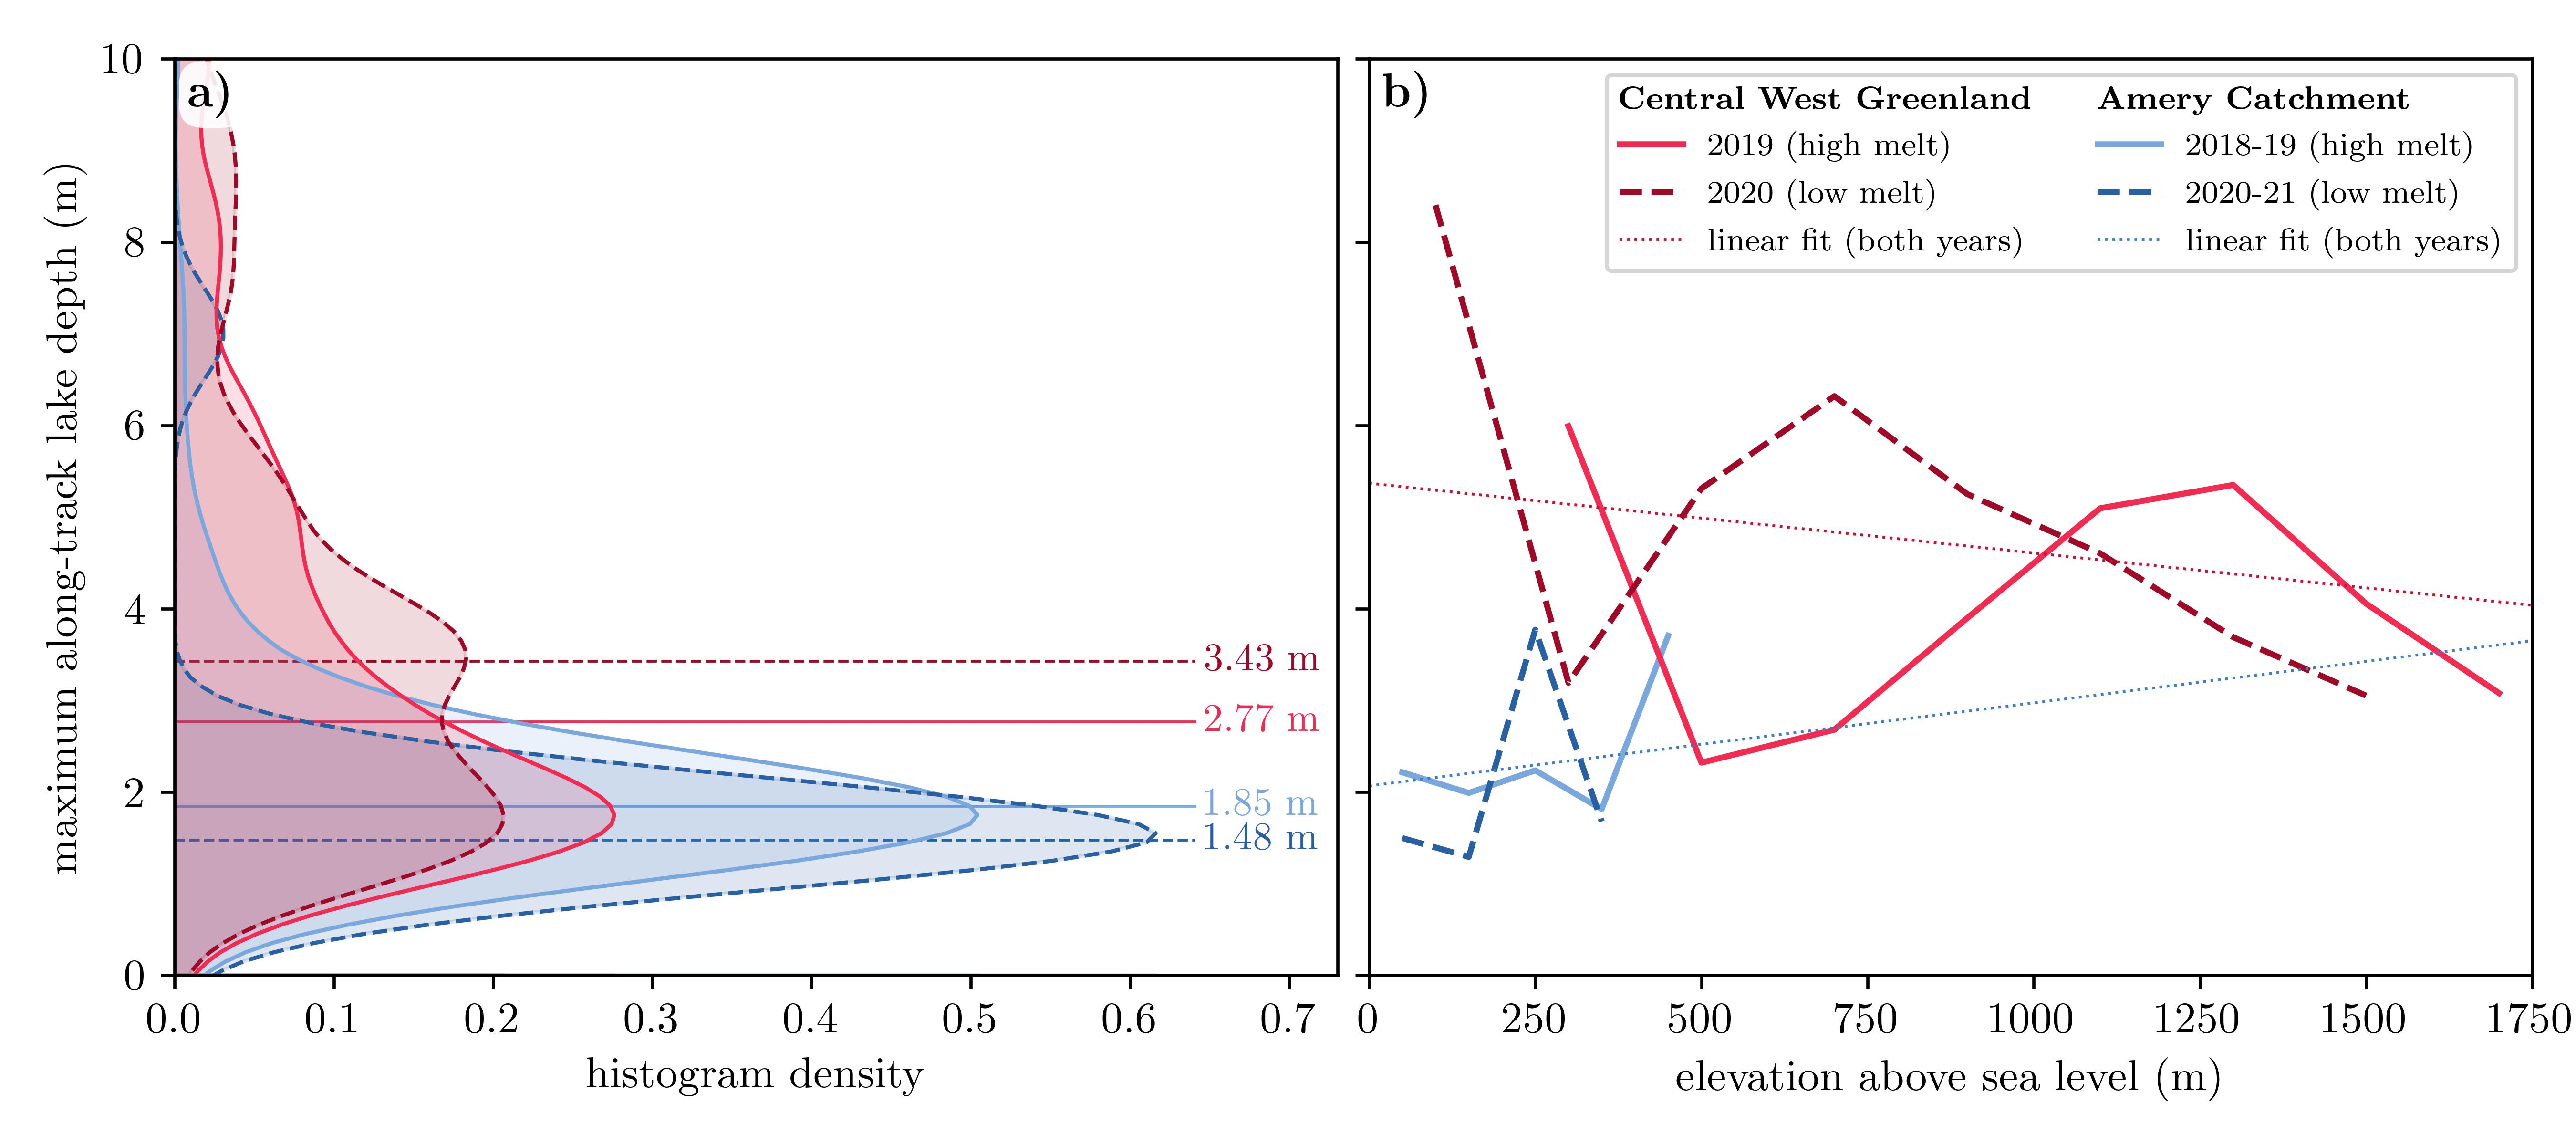

In [2]:
# input data
df_lakes = pd.read_csv('../data/lakestats_methods_paper.csv')

# some plotting settings
plotname = '../figures/fig11-depth_distributions_elevation.jpg'
depthlims = [0,10]
plt.rcParams.update({'font.size': 11,'text.usetex': True,'font.family': 'Optima'})
melt_seasons = ['2018-19','2020-21','2019', '2020']
season_type = {'2018-19': 'high_melt','2020-21': 'low_melt','2019': 'high_melt','2020': 'low_melt'}
colors = {'GrIS': '#D00C33', # Greenland flag
          'AIS': '#3A7DCE'} # Antarctica, Graham Bartram Design
line_sty = {'low_melt': '--','high_melt': '-'}
density = True
collapse = True

# create figure and axes
fig = plt.figure(figsize=[9, 4], dpi=100)
gs = fig.add_gridspec(ncols=2, nrows=1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)

###################################################
# plot of depth distribution densities
ax = ax1
step = 0.25
step_s = 0.1
smooth = 1
uplim = 20
bins = np.arange(-2*step,uplim+2*step,step)
mids = bins[:-1] + np.diff(bins)/2
bins_s = np.arange(-2*step_s,uplim+2*step_s,step_s)
mids_s = bins_s[:-1] + np.diff(bins_s)/2
wdw = int(np.ceil(smooth/step_s))

hdls = []
maxval = 0
medians = []
cols = []
lstys = []
# loop though all the melt seasons
for melt_season in melt_seasons:

    # get the data for this melt season
    sheet = 'AIS' if len(melt_season)>4 else 'GrIS'
    dfi = df_lakes[(df_lakes.melt_season == melt_season) & (~np.isnan(df_lakes.depth_95th_pctl))]
    sheet_name = 'Antarctic Ice Sheet' if sheet=='AIS' else 'Greenland Ice Sheet'

    # get the median max depth and distribution
    medians.append(dfi.depth_95th_pctl.median())
    depths = np.clip(dfi.depth_95th_pctl, 0, uplim-step/2)
    hist = np.histogram(depths, bins=bins, density=density)[0]
    hist_s = np.histogram(depths, bins=bins_s, density=density)[0]
    hist_smooth = pd.Series(hist_s).rolling(window=wdw*3, center=True, min_periods=1, win_type='gaussian').mean(std=wdw/2)

    # plot the distribution
    coladj = 1.3
    amt = coladj if season_type[melt_season] == 'high_melt' else 1/coladj
    thiscol = adjust_lightness(colors[sheet], amount=amt)
    cols.append(thiscol)
    # plot line
    hdl, = ax.plot(hist_smooth, mids_s, color=thiscol, lw=1.0, alpha=1.0,
                   label='%s, %s (%s)'%(sheet,melt_season,season_type[melt_season].replace('_', ' ')), 
                   ls=line_sty[season_type[melt_season]])
    lstys.append(line_sty[season_type[melt_season]])
    hist_smooth.iloc[0] = 0 # to make the patches align with zero at the y axis
    hist_smooth.iloc[-1] = 0 # to make the patches align with zero at the y axis
    # fill distribution with color
    ax.fill_between(hist_smooth,mids_s, 0, color=thiscol, alpha=0.15)
    hdls.append(hdl)
    maxval = np.max((maxval, np.max(hist_smooth)))

# label
if density:
    ax.set_xlabel('histogram density')
else:
    ax.set_xlabel('number of lakes per %g m depth bin')

# plot the median depths
xtent = np.array((0, 1.04*maxval))
for i, median in enumerate(medians): 
    ax.plot(xtent,[median]*2, lw=0.7, color=cols[i], 
                       label = 'median: %.2f m' % median,
                       ls=lstys[i], zorder=-100)
    ax.text(xtent[1]*1.01, median, '%.2f m' % median, ha='left', va='center', color=cols[i], fontsize=10)
    
ax.set_ylabel('maximum along-track lake depth (m)')
ax.set_xlim(xtent*1.14)
ax.set_ylim(depthlims)
ax.tick_params(axis='both')

###################################################
# plot of elevation vs. depth
ax = ax2
df_lakes=df_lakes[~np.isnan(df_lakes.depth_95th_pctl)]

# get all the relevant data per ice sheet / melt season
dfg = df_lakes[df_lakes.ice_sheet == 'GrIS']
dfg19 = df_lakes[(df_lakes.ice_sheet == 'GrIS') & (df_lakes.melt_season=='2019')]
dfg20 = df_lakes[(df_lakes.ice_sheet == 'GrIS') & (df_lakes.melt_season=='2020')]
dfa = df_lakes[df_lakes.ice_sheet == 'AIS']
dfa18 = df_lakes[(df_lakes.ice_sheet == 'AIS') & (df_lakes.melt_season=='2018-19')]
dfa20 = df_lakes[(df_lakes.ice_sheet == 'AIS') & (df_lakes.melt_season=='2020-21')]

# calculate binned statistic by elevation
stat='mean'
step = 200
maxelev = 2000
bins = np.arange(0, maxelev+step/2, step)
mids_gre = bins[:-1] + np.diff(bins)/2
depthelev_gre = binned_statistic(dfg.surface_elevation, dfg.depth_95th_pctl, statistic=stat, bins=bins)
depthelev_gre19 = binned_statistic(dfg19.surface_elevation, dfg19.depth_95th_pctl, statistic=stat, bins=bins)
depthelev_gre20 = binned_statistic(dfg20.surface_elevation, dfg20.depth_95th_pctl, statistic=stat, bins=bins)
step = 100
maxelev = 500
bins = np.arange(0, maxelev+step/2, step)
mids_ant = bins[:-1] + np.diff(bins)/2
depthelev_ant = binned_statistic(dfa.surface_elevation, dfa.depth_95th_pctl, statistic=stat, bins=bins)
depthelev_ant18 = binned_statistic(dfa18.surface_elevation, dfa18.depth_95th_pctl, statistic=stat, bins=bins)
depthelev_ant20 = binned_statistic(dfa20.surface_elevation, dfa20.depth_95th_pctl, statistic=stat, bins=bins)

# plot the binned statistics
coladj = 1.3
amt = coladj if season_type[melt_season] == 'high_melt' else 1/coladj
thiscol = adjust_lightness(colors[sheet], amount=amt)
a18, = ax.plot(mids_ant, depthelev_ant18.statistic, ls='-', c=adjust_lightness(colors['AIS'],1.3), label='2018-19 (high melt)')
a20, = ax.plot(mids_ant, depthelev_ant20.statistic, ls='--', c=adjust_lightness(colors['AIS'],1/1.3), label='2020-21 (low melt)')
g19, = ax.plot(mids_gre, depthelev_gre19.statistic, ls='-', c=adjust_lightness(colors['GrIS'],1.3), label='2019 (high melt)')
g20, = ax.plot(mids_gre, depthelev_gre20.statistic, ls='--', c=adjust_lightness(colors['GrIS'],1/1.3), label='2020 (low melt)')

# run linear regression on depth vs. elevation
afit = linregress(dfa.surface_elevation, dfa.depth_95th_pctl, alternative='greater')
gfit = linregress(dfg.surface_elevation, dfg.depth_95th_pctl, alternative='less')
xs = np.arange(0,1751)
ap, = ax.plot(xs, afit.intercept+xs*afit.slope, c=colors['AIS'], ls=':', lw=0.7, label='linear fit (both years)')
gp, = ax.plot(xs, gfit.intercept+xs*gfit.slope, c=colors['GrIS'], ls=':', lw=0.7, label='linear fit (both years)')

# axes management
ax.set_xlabel('elevation above sea level (m)')
ax.set_xlim((0, 1750))
empty_hdl = Patch(visible=False, label='')
cwhdl = Patch(visible=False, label=r'\textbf{Central West Greenland}')
bchdl = Patch(visible=False, label=r'\textbf{Amery Catchment}')
hdls = [cwhdl, g19, g20, gp, bchdl, a18, a20, ap]
leg = ax.legend(handles=hdls, loc='upper right', fontsize=8, ncols=2)
style_legend_titles_by_removing_handles(leg)
plt.setp(ax.get_yticklabels(), visible=False)

fig.tight_layout(pad=1, w_pad=0, h_pad=0)

# add panel labels
for i,ax in enumerate([ax1,ax2]):
    ax.text(0.012, 0.987, r'\textbf{%s)}' % chr(ord('a') + i), transform=ax.transAxes, ha='left', va='top', fontsize=12,
           bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0))

# save the figure and show plot
fig.savefig(plotname, dpi=600)
plt.close(fig)
display(Image(plotname))

In [3]:
print('Amery Catchment:', afit)
print('Central West Greenland:', gfit)

Amery Catchment: LinregressResult(slope=0.0009052500485052125, intercept=2.0661955594062, rvalue=0.04893329730966493, pvalue=0.09316106073979195, stderr=0.0006843523074686003, intercept_stderr=0.1113955332581241)
Central West Greenland: LinregressResult(slope=-0.0007612864657000194, intercept=5.369173646070049, rvalue=-0.05239212713686628, pvalue=0.1237599309479863, stderr=0.0006575377971383149, intercept_stderr=0.7952702483086457)
